#                                        # 911 call Analysis

# Introduction - Description of the problem

<b>

911.csv contains the call details to 911 from different locations. Provide  as many insights as possible which will assist first responders for prioritizing their focus. First responders would like to know which area had maximum calls and see whether there is any modeling possible<br><br>
Description of the data and how it will be used to solve the problem.<br>

Please review the Results and Discussion after every analysis below

</b>

# Description of the data and how it will be used to solve the problem.

Data - 911.csv, Dataset source - www.Kaggle.com

    lat : String variable, Latitude
    lng: String variable, Longitude
    desc: String variable, Description of the Emergency Call
    zip: String variable, Zipcode
    title: String variable, Title
    timeStamp: String variable, YYYY-MM-DD HH:MM:SS
    twp: String variable, Township
    addr: String variable, Address
    e: String variable, Dummy variable (always 1)
    

# Methodology

Below are the different steps that will be showcased in this project
Exploratory analysis 1. of the data
2. Visualization of data using sea born
3. Identification of a major spike and visualizations
4. Data Summarization and visualization using Seaborn and WordCloud
5. Visualization of the Townships from where calls originated using Folium
6. Identification of the different neighborhoods using Foursquare API
7. Logistic regression on the data and analysis
8. Clustering of the data
9. Conclusion

# Results section

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize

In [2]:
# Import KMeans and graphic libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import folium
from geopy.geocoders import Nominatim

In [4]:
CLIENT_ID='ZOO51K0TRLO3V1BXETAEBMWHHIO2C0DXTW05UWSNGTBS5G0E'
CLIENT_SECRET='ODKWIW1VFAKDYQ1PQNNJQU1RQDCA2QMV0UNTHXJHPBCR422B'
VERSION='20181511'
LIMIT=30
RADIUS = 500

In [5]:
df = pd.read_csv('911.csv')

In [6]:
df.columns

Index(['lat', 'lng', 'desc', 'zip', 'title', 'timeStamp', 'twp', 'addr', 'e'], dtype='object')

In [7]:
# find out the size of the dataset
df.shape

(423909, 9)

In [8]:
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [9]:
df.info()
# Note that all the columns are not null 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423909 entries, 0 to 423908
Data columns (total 9 columns):
lat          423909 non-null float64
lng          423909 non-null float64
desc         423909 non-null object
zip          371780 non-null float64
title        423909 non-null object
timeStamp    423909 non-null object
twp          423750 non-null object
addr         423909 non-null object
e            423909 non-null int64
dtypes: float64(3), int64(1), object(5)
memory usage: 21.0+ MB


In [10]:
# Column title is in the format <short code> : <description>. Creating a new column so that data exploration would be easier

df['Type code'] = df['title'].apply(lambda x : x.split(':')[0])

In [11]:
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,Type code
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1,EMS
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,EMS
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1,Fire
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1,EMS
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,EMS


In [12]:
# twp apparently is Township. Just renaming the column to give it better sense
df = df.rename(columns={'twp': 'Township'})

In [13]:
#Convering the zip to String removing and removing the decimal value
# Change nan to Not available to make it move readable
df['zip'] = df['zip'].astype(str)
df['zip'] = df['zip'].apply(lambda x : str(x).split('.')[0])
df['zip'] = df['zip'].apply(lambda x: 'Not Available' if x =='nan' else x)

In [14]:
df.head()

,lat,lng,desc,zip,title,timeStamp,Township,addr,e,Type code
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1,EMS
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,EMS
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1,Fire
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1,EMS
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,Not Available,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,EMS


<b>Lets start analyzing the data. Lets have a high level view on how the 911 calls are scattered, is it focused on a particular area or just scattered through out. Just to make it interesting , lets color code it based on the different title</b>

Text(0.5,1,'Area from where 911 was called, color coded by reason')

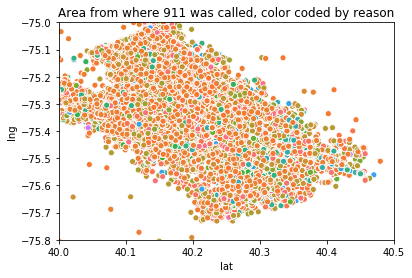

In [15]:
sns.scatterplot(x='lat',y='lng',hue='title',data=df,legend=False)
plt.ylim(-75.8, -75)
plt.xlim(40, 40.5)
plt.title('Area from where 911 was called, color coded by reason')

<b>Looks like this does not help. Though it gives a general idea on the spread, it does not help in making any decisions. This is a crowded graph and is causing over plotting. Note that the legend is purposefully removed to make the graph visible</b>

<b> Lets get in to the dataset and find out moe about the data. Below table indicates that the maximum calls came from LOWER MERION. Below table shows the top 5 and bottom 5 Townships from where the calls originated</b>

In [16]:
print('911 calls - Top 5 Townships')
print(df['Township'].value_counts().head(5))
print(' ')
print('911 calls - Bottom 5 Townships')
print(df['Township'].value_counts().tail(5))

911 calls - Top 5 Townships
LOWER MERION    36441
ABINGTON        25835
NORRISTOWN      23883
UPPER MERION    22694
CHELTENHAM      19629
Name: Township, dtype: int64
 
911 calls - Bottom 5 Townships
HATFIELD BORO    865
BRYN ATHYN       835
GREEN LANE       259
PHILA COUNTY     172
LEHIGH COUNTY     95
Name: Township, dtype: int64


<b> Lets start exploring the data. As one can see the 911 calls happen majorly for Vehicle accidents. As you can see top 2 reasons are related to Vehicles</b>

In [183]:
df['title'] = df['title'].astype(str)
print("Top 5 ")
print(df['title'].value_counts().head(5))
print("Bottom 5 ")
print(df['title'].value_counts().tail(5))

Top 5 
Traffic: VEHICLE ACCIDENT -    98401
Traffic: DISABLED VEHICLE -    31871
Fire: FIRE ALARM               24380
EMS: FALL VICTIM               21253
EMS: RESPIRATORY EMERGENCY     21158
Name: title, dtype: int64
Bottom 5 
EMS: HIT + RUN                1
Fire: POISONING               1
Fire: UNRESPONSIVE SUBJECT    1
EMS: PUBLIC SERVICE           1
Fire: PRISONER IN CUSTODY     1
Name: title, dtype: int64


In [18]:
top5titles = ['Traffic: VEHICLE ACCIDENT -','Traffic: DISABLED VEHICLE -','Fire: FIRE ALARM','EMS: FALL VICTIM','EMS: RESPIRATORY EMERGENCY']
df_top5titles = df[df['title'].isin(top5titles)]
df_top5titles.head()

,lat,lng,desc,zip,title,timeStamp,Township,addr,e,Type code
7,40.217286,-75.405182,COLLEGEVILLE RD & LYWISKI RD; SKIPPACK; Stati...,19426,EMS: RESPIRATORY EMERGENCY,2015-12-10 16:17:05,SKIPPACK,COLLEGEVILLE RD & LYWISKI RD,1,EMS
9,40.102398,-75.291458,BLUEROUTE & RAMP I476 NB TO CHEMICAL RD; PLYM...,19462,Traffic: VEHICLE ACCIDENT -,2015-12-10 17:35:41,PLYMOUTH,BLUEROUTE & RAMP I476 NB TO CHEMICAL RD,1,Traffic
10,40.231990,-75.251891,RT202 PKWY & KNAPP RD; MONTGOMERY; 2015-12-10 ...,Not Available,Traffic: VEHICLE ACCIDENT -,2015-12-10 17:33:50,MONTGOMERY,RT202 PKWY & KNAPP RD,1,Traffic
11,40.084161,-75.308386,BROOK RD & COLWELL LN; PLYMOUTH; 2015-12-10 @ ...,19428,Traffic: VEHICLE ACCIDENT -,2015-12-10 16:32:10,PLYMOUTH,BROOK RD & COLWELL LN,1,Traffic
12,40.174131,-75.098491,BYBERRY AVE & S WARMINSTER RD; UPPER MORELAND;...,19040,Traffic: VEHICLE ACCIDENT -,2015-12-10 17:15:49,UPPER MORELAND,BYBERRY AVE & S WARMINSTER RD,1,Traffic


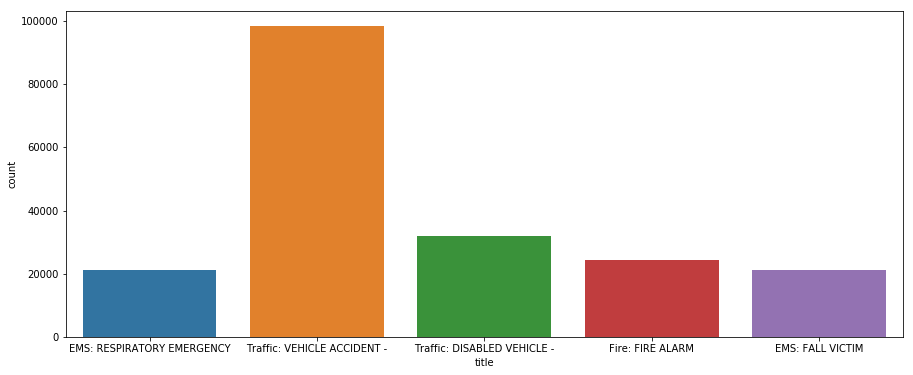

In [19]:
# Visualize the 911 calls for the top 5 titles
plt.figure(figsize=(15,6))
sns.countplot(x='title',data=df_top5titles)
plt.show()

<b>Looks like there are three different type codes available for the title.. 
1. EMS
2. Fire
3. Traffic<br><br>
Below is the viualization of the 911 calls against these three categories</b>

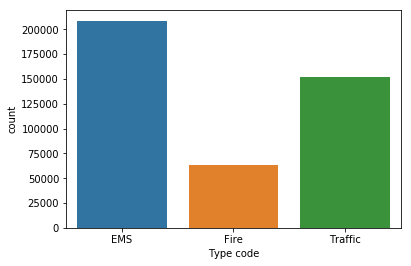

In [20]:
sns.countplot(x='Type code',data=df)

<b>Lets explore the calls based on different time parameters.. Note that the type needs to be changed before moving ahead</b>

In [21]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [22]:
df.info() # Note that the type for corrected

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423909 entries, 0 to 423908
Data columns (total 10 columns):
lat          423909 non-null float64
lng          423909 non-null float64
desc         423909 non-null object
zip          423909 non-null object
title        423909 non-null object
timeStamp    423909 non-null datetime64[ns]
Township     423750 non-null object
addr         423909 non-null object
e            423909 non-null int64
Type code    423909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 22.6+ MB


In [23]:
#Create three different columns to capture Hour, month and Week day seperately 
df['Hour'] = df['timeStamp'].apply(lambda x: x.hour)
df['Month'] = df['timeStamp'].apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
                                                                 7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
df['Week Day'] = df['timeStamp'].apply(lambda x: x.dayofweek).map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df['Year'] = df['timeStamp'].apply(lambda x: x.year)

In [24]:
df.head(2)

,lat,lng,desc,zip,title,timeStamp,Township,addr,e,Type code,Hour,Month,Week Day,Year
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1,EMS,17,Dec,Thu,2015
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,EMS,17,Dec,Thu,2015


<b>Visualize the count of calls originated based on Month, week day and hour<b>

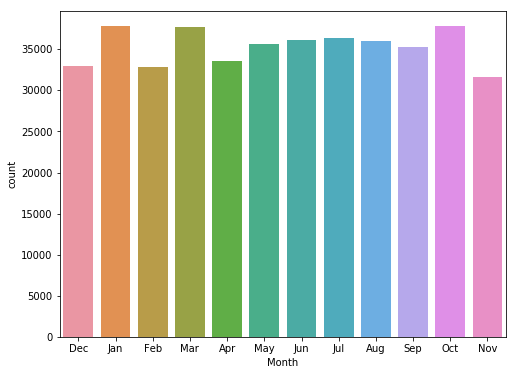

In [25]:
plt.figure(figsize=(8,6))
sns.countplot(x=df['Month'])

<b>No definite pattern seen. Jan, Mar and Oct seems to be the highest hitters.. Other than that, no obvious pattern is seen. Lets move forward</b>

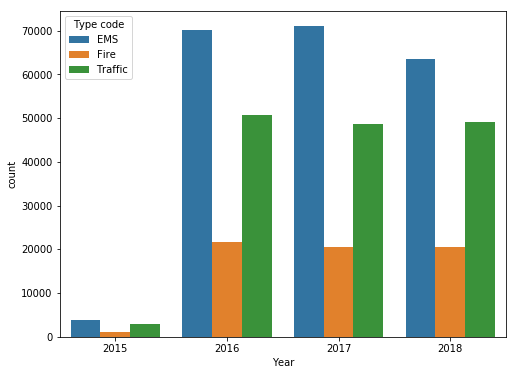

In [26]:
plt.figure(figsize=(8,6))
sns.countplot(x='Year', hue='Type code', data=df)

<b>There seems to be a substantial jump in the number of call from 2015 to 2016.. This might be an anomaly.
For all the years, the pattern seems to be the same for all three type codes, EMS type code is at the top , followed by Traffic and Fire</b>

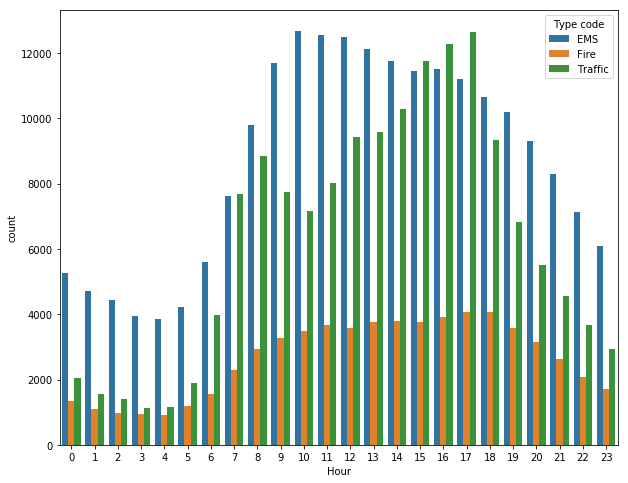

In [27]:
plt.figure(figsize=(10,8))
sns.countplot(x='Hour', hue='Type code', data=df)

<b>
    1. Its interesting to note that, maximum calls happened between  4 PM and 6 PM for Traffic. May be because, that is the time when folks were rushing home
    2. EMS related calls peaked at 09:00 AM and 10:00 AM and reducing as day progreses
    3. Fire related calls happened primariy during the business hours, reducing sharply after 06:00 PM
</b>

<b>Now lets try to plot the call on a time scale</b>

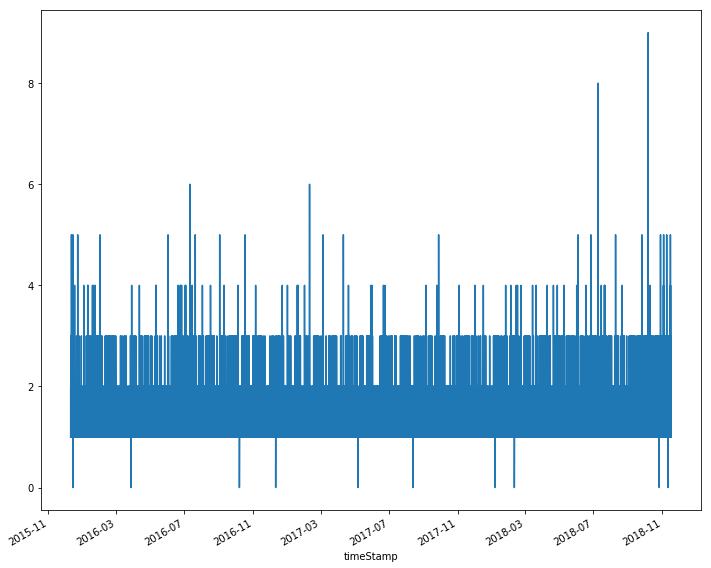

In [28]:
plt.figure(figsize=(10,8))
df.groupby('timeStamp').count()['Township'].plot()
plt.tight_layout()

The graph seems to be over crowded. Lets convert the timestamp to date and see whether the problem is getting sorted out

In [29]:
df['Date'] = df['timeStamp'].apply(lambda x : x.date())

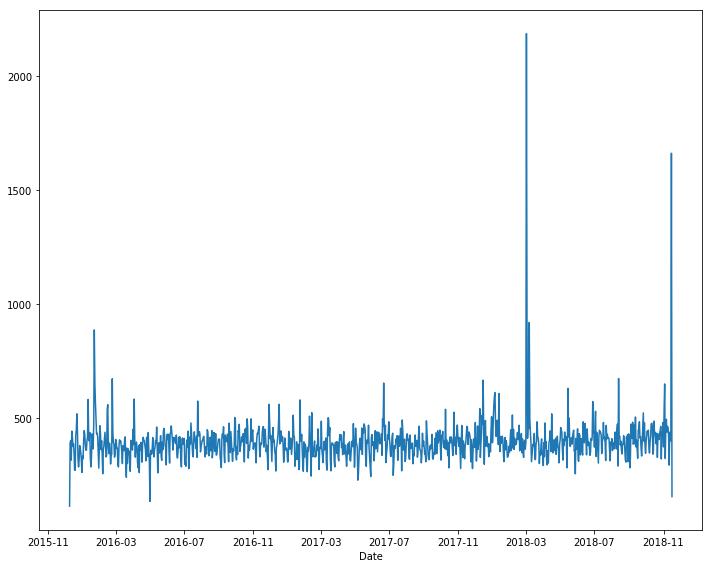

In [30]:
plt.figure(figsize=(10,8))
df.groupby('Date').count()['Township'].plot()
plt.tight_layout()

<b>What happened during the 2018 time frame why this spike.. Lets try to drill down a bit more and try to figure out</b>

In [31]:
df_year2018 = df[df['Year']==2018]

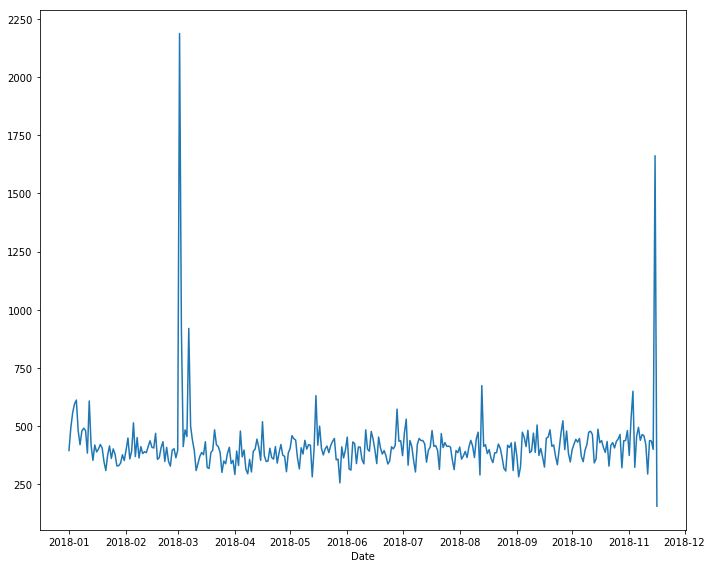

In [32]:
plt.figure(figsize=(10,8))
df_year2018.groupby('Date').count()['Township'].plot()
plt.tight_layout()

During the period of March, calls seems to have spiked.. Interesting. Lets drill down a bit more , this time with a hue on Type code

In [33]:
df_year2018_march = df_year2018[df_year2018['Month']=='Mar']

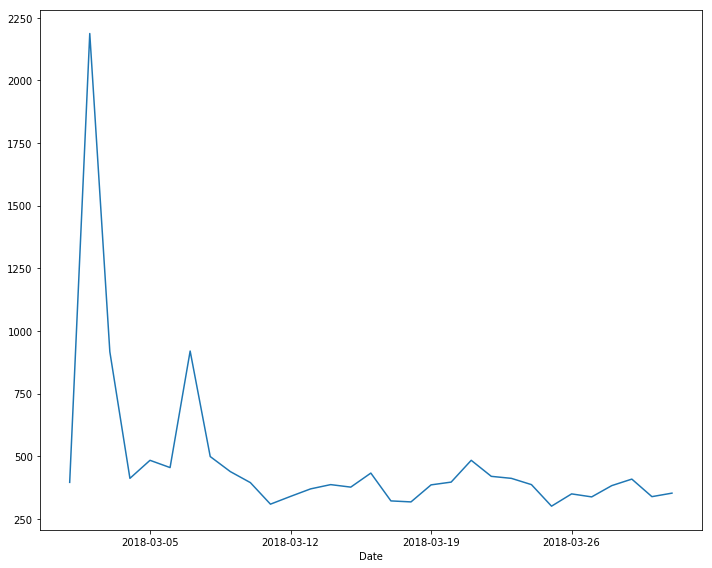

In [34]:
plt.figure(figsize=(10,8))
df_year2018_march.groupby('Date').count()['Township'].plot()
plt.tight_layout()

In [35]:
df_year2018_march['Dayno'] = df_year2018_march['Date'].apply(lambda x : x.day )
df_year2018_march_df = df_year2018_march[df_year2018_march['Dayno'] ==1]

c:\users\ibm_admin\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


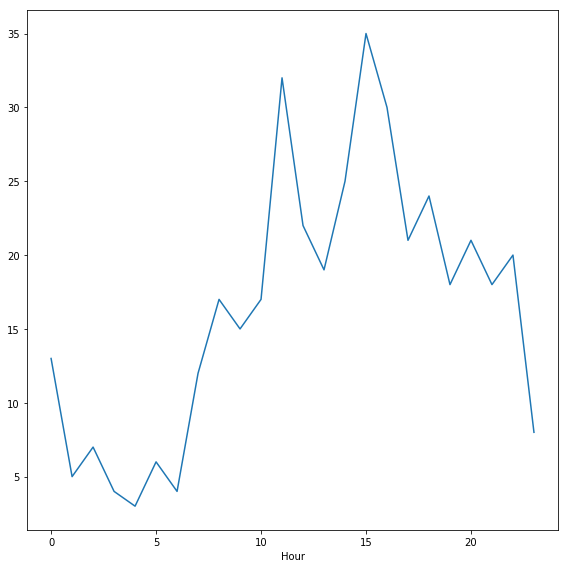

In [36]:
plt.figure(figsize=(8,8))
df_year2018_march_df.groupby('Hour').count()['Township'].plot()
plt.tight_layout()

In [37]:
df_year2018_march_df_spiked  = df_year2018_march_df[df_year2018_march_df['Hour'].isin([12,13,14,15,16])]

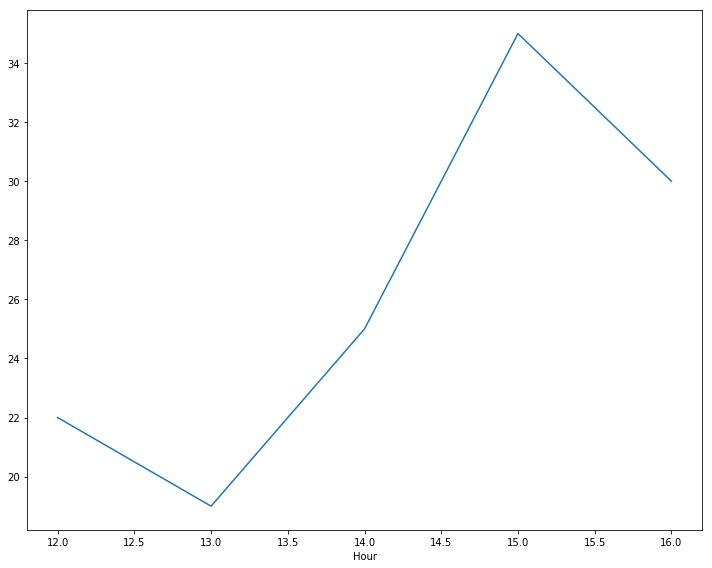

In [38]:
plt.figure(figsize=(10,8))
df_year2018_march_df_spiked.groupby('Hour').count()['Township'].plot()
plt.tight_layout()

<b>Call spiked at 1:15:31<b>

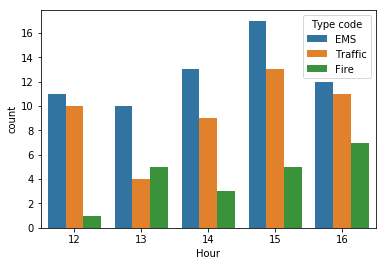

In [39]:
sns.countplot(x='Hour', hue='Type code', data=df_year2018_march_df_spiked)

Above are the different calls that happened during the piked period

In [40]:
df_year2018_march_df_spiked.head(2)

,lat,lng,desc,zip,title,timeStamp,Township,addr,e,Type code,Hour,Month,Week Day,Year,Date,Dayno
315040,40.236172,-75.278918,PENN ST & PARK DR; LANSDALE; Station 345; 201...,19446,EMS: ALLERGIC REACTION,2018-03-01 12:00:10,LANSDALE,PENN ST & PARK DR,1,EMS,12,Mar,Thu,2018,2018-03-01,1
315043,40.148557,-75.332151,W GERMANTOWN PIKE & SCENIC RD; EAST NORRITON; ...,19403,Traffic: VEHICLE ACCIDENT -,2018-03-01 12:01:49,EAST NORRITON,W GERMANTOWN PIKE & SCENIC RD,1,Traffic,12,Mar,Thu,2018,2018-03-01,1


In [41]:
address = 'Philadelphia,USA'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude,longitude)

mymap = folium.Map(location = [latitude, longitude],zoom_start=10)
for lat,long,name in zip(df_year2018_march_df_spiked['lat'],df_year2018_march_df_spiked['lng'],df_year2018_march_df_spiked['Township']):    
   label = '{}'.format(name)
   label = folium.Popup(label, parse_html=True)
   folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#4186FF',
        fill_opacity=0.7).add_to(mymap) 
mymap

39.9524152 -75.1635755


<b>Above are the coordinates in the map from where the calls happened<b>

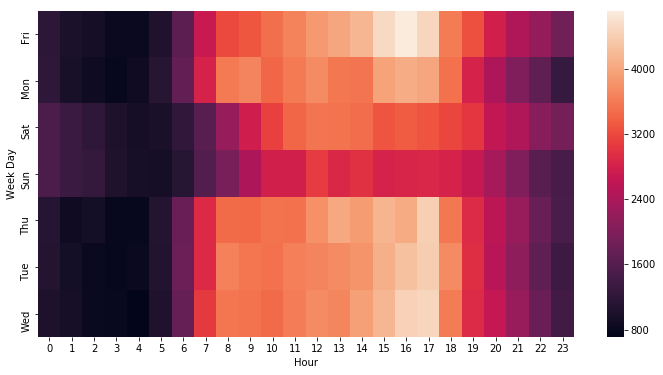

In [42]:
plt.figure(figsize=(12,6))
sns.heatmap(df.groupby(by=['Week Day','Hour']).count()['Type code'].unstack())

<b>Heat map on the 911 calls.. 17:00 during week days seems to be the time when most of the calls happen</b>

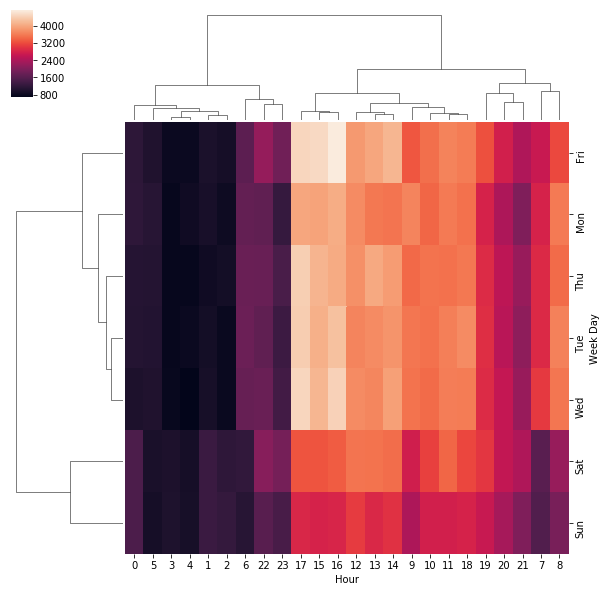

In [43]:
sns.clustermap(df.groupby(by=['Week Day','Hour']).count()['Type code'].unstack())

<b>Lets Generate a work cloud on the titles to see what pops up on the entire Dataset </b>

In [44]:
df['title'][4:].to_csv('title.csv')
cat = open('title.csv', 'r').read()

In [45]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [46]:
cat_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

In [47]:
cat_wc.generate(cat)

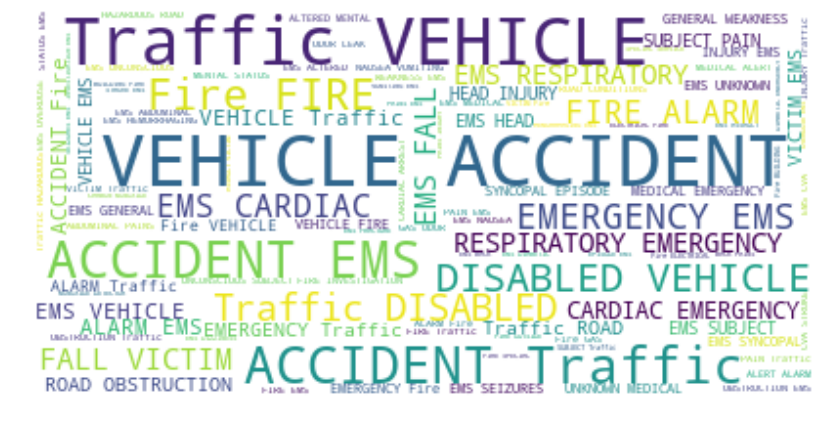

In [48]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(cat_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<b>As expected , Vehicle accident and Traffic seems to be the one that is prominent <b>

<b> Now lets explore the venues around the areas when the spike happened. Above 2018 dataset is going to be the source</b>

In [54]:
df_year2018_march_df_spiked.head(25)

,lat,lng,desc,zip,title,timeStamp,Township,addr,e,Type code,Hour,Month,Week Day,Year,Date,Dayno
315040,40.236172,-75.278918,PENN ST & PARK DR; LANSDALE; Station 345; 201...,19446,EMS: ALLERGIC REACTION,2018-03-01 12:00:10,LANSDALE,PENN ST & PARK DR,1,EMS,12,Mar,Thu,2018,2018-03-01,1
315043,40.148557,-75.332151,W GERMANTOWN PIKE & SCENIC RD; EAST NORRITON; ...,19403,Traffic: VEHICLE ACCIDENT -,2018-03-01 12:01:49,EAST NORRITON,W GERMANTOWN PIKE & SCENIC RD,1,Traffic,12,Mar,Thu,2018,2018-03-01,1
315044,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401,EMS: CARDIAC EMERGENCY,2018-03-01 12:05:52,NORRISTOWN,AIRY ST & SWEDE ST,1,EMS,12,Mar,Thu,2018,2018-03-01,1
315045,40.118073,-75.355405,LAFAYETTE ST & JAMISON ALY; NORRISTOWN; Stati...,19401,EMS: DIABETIC EMERGENCY,2018-03-01 12:03:36,NORRISTOWN,LAFAYETTE ST & JAMISON ALY,1,EMS,12,Mar,Thu,2018,2018-03-01,1
315046,40.329643,-75.624420,MONTGOMERY AVE & E 5TH ST; DOUGLASS; Station ...,19512,EMS: NAUSEA/VOMITING,2018-03-01 12:03:07,DOUGLASS,MONTGOMERY AVE & E 5TH ST,1,EMS,12,Mar,Thu,2018,2018-03-01,1
315047,40.118816,-75.119232,OLD YORK RD & WOODLAND RD; ABINGTON; 2018-03-0...,19001,Traffic: VEHICLE ACCIDENT -,2018-03-01 12:02:10,ABINGTON,OLD YORK RD & WOODLAND RD,1,Traffic,12,Mar,Thu,2018,2018-03-01,1
315048,40.114879,-75.285477,W GERMANTOWN PIKE & LAUNFALL RD; PLYMOUTH; 201...,19462,Traffic: VEHICLE ACCIDENT -,2018-03-01 12:03:48,PLYMOUTH,W GERMANTOWN PIKE & LAUNFALL RD,1,Traffic,12,Mar,Thu,2018,2018-03-01,1
315049,40.122419,-75.360572,W MAIN ST & SELMA ST; NORRISTOWN; 2018-03-01 @...,19401,Traffic: VEHICLE ACCIDENT -,2018-03-01 12:04:12,NORRISTOWN,W MAIN ST & SELMA ST,1,Traffic,12,Mar,Thu,2018,2018-03-01,1
315050,40.072244,-75.132597,OLD YORK RD & WEBB RD; CHELTENHAM; Station 35...,19027,EMS: CARDIAC EMERGENCY,2018-03-01 12:07:12,CHELTENHAM,OLD YORK RD & WEBB RD,1,EMS,12,Mar,Thu,2018,2018-03-01,1
315051,40.179512,-75.277732,DEKALB PIKE & MORRIS RD; WHITPAIN; 2018-03-01 ...,19422,Traffic: VEHICLE ACCIDENT -,2018-03-01 12:07:22,WHITPAIN,DEKALB PIKE & MORRIS RD,1,Traffic,12,Mar,Thu,2018,2018-03-01,1


In [72]:
df_venue_all = pd.DataFrame()
venues = None
for lat,long,name  in zip(df_year2018_march_df_spiked['lat'],df_year2018_march_df_spiked['lng'],df_year2018_march_df_spiked['Township']):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, RADIUS, LIMIT)
    results = requests.get(url).json()
    try:
        venues = results['response']['venues']
        df_venues = json_normalize(venues)
        #print(df_venues.shape)
        df_venues['Township'] = name
        df_venues['Latitude'] = lat
        df_venues['Longitude'] = long
        df_venue_all = df_venue_all.append(df_venues)
    except:
        pass

In [73]:
df_venue_all.columns

Index(['Latitude', 'Longitude', 'Township', 'categories', 'delivery.id',
       'delivery.provider.icon.name', 'delivery.provider.icon.prefix',
       'delivery.provider.icon.sizes', 'delivery.provider.name',
       'delivery.url', 'events.count', 'events.summary', 'hasPerk', 'id',
       'location.address', 'location.cc', 'location.city', 'location.country',
       'location.crossStreet', 'location.distance',
       'location.formattedAddress', 'location.labeledLatLngs', 'location.lat',
       'location.lng', 'location.neighborhood', 'location.postalCode',
       'location.state', 'name', 'referralId', 'venuePage.id'],
      dtype='object')

In [74]:
df_venue_all.drop(['delivery.id',
       'delivery.provider.icon.name', 'delivery.provider.icon.prefix',
       'delivery.provider.icon.sizes', 'delivery.provider.name',
       'delivery.url', 'events.count', 'events.summary', 'hasPerk', 'id','location.cc', 'location.city', 'location.country',
        'location.formattedAddress', 'location.labeledLatLngs','location.state', 'referralId', 'venuePage.id' ],inplace=True, axis=1)

In [75]:
df_venue_all.head()

,Latitude,Longitude,Township,categories,location.address,location.crossStreet,location.distance,location.lat,location.lng,location.neighborhood,location.postalCode,name
0,40.236172,-75.278918,LANSDALE,"[{'id': '4f4533814b9074f6e4fb0106', 'name': 'M...",400 Penn St,NaN,46,40.235784,-75.279125,NaN,19446,Penndale Middle School
1,40.236172,-75.278918,LANSDALE,"[{'id': '4bf58dd8d48988d1e8941735', 'name': 'B...",NaN,NaN,35,40.236444,-75.279131,NaN,19446,Line Street Park
2,40.236172,-75.278918,LANSDALE,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",300 E. Main St.,NaN,43,40.236525,-75.279143,NaN,NaN,Memorial Park
3,40.236172,-75.278918,LANSDALE,[],Broad street,NaN,598,40.241229,-75.276517,NaN,19446,Royal Cleaners
4,40.236172,-75.278918,LANSDALE,"[{'id': '4bf58dd8d48988d1fb941735', 'name': 'H...",NaN,Line St. & Penn St.,204,40.237439,-75.280663,NaN,NaN,Henning Scale Models


In [76]:
def get_category(row):
    category_list =  row['categories']
    if len(category_list)==0:
        return None
    else:
        return category_list[0]['name']

In [77]:
df_venue_all['categories'] = df_venue_all.apply(get_category,axis=1)
df_venue_all.head()

,Latitude,Longitude,Township,categories,location.address,location.crossStreet,location.distance,location.lat,location.lng,location.neighborhood,location.postalCode,name
0,40.236172,-75.278918,LANSDALE,Middle School,400 Penn St,NaN,46,40.235784,-75.279125,NaN,19446,Penndale Middle School
1,40.236172,-75.278918,LANSDALE,Baseball Field,NaN,NaN,35,40.236444,-75.279131,NaN,19446,Line Street Park
2,40.236172,-75.278918,LANSDALE,Park,300 E. Main St.,NaN,43,40.236525,-75.279143,NaN,NaN,Memorial Park
3,40.236172,-75.278918,LANSDALE,None,Broad street,NaN,598,40.241229,-75.276517,NaN,19446,Royal Cleaners
4,40.236172,-75.278918,LANSDALE,Hobby Shop,NaN,Line St. & Penn St.,204,40.237439,-75.280663,NaN,NaN,Henning Scale Models


In [78]:
df_venue_all.groupby('Township').count()['Latitude'].sort_values(ascending=False)

Township
LOWER MERION         450
NORRISTOWN           270
HORSHAM              270
ABINGTON             240
POTTSTOWN            180
UPPER GWYNEDD        180
WHITEMARSH           180
PLYMOUTH             180
CHELTENHAM           150
UPPER MORELAND       150
EAST NORRITON        150
MONTGOMERY           150
WHITPAIN             150
WEST NORRITON        120
WORCESTER            120
LIMERICK              90
AMBLER                60
SOUDERTON             60
SPRINGFIELD           60
UPPER PROVIDENCE      60
LOWER PROVIDENCE      60
LOWER MORELAND        60
CHESTER COUNTY        60
UPPER DUBLIN          60
HATBORO               60
RED HILL              30
UPPER MERION          30
DOUGLASS              30
EAST GREENVILLE       30
JENKINTOWN            30
FRANCONIA             30
SKIPPACK              30
LANSDALE              30
WEST POTTSGROVE       30
WEST CONSHOHOCKEN     30
PERKIOMEN             30
LOWER SALFORD         30
Name: Latitude, dtype: int64

In [184]:
df_venue_all.groupby('categories').count()['Latitude'].sort_values(ascending=False)

categories
Office                                      137
Building                                    108
Doctor's Office                              84
Automotive Shop                              66
Gas Station                                  59
Church                                       58
Bank                                         51
Pizza Place                                  46
City                                         46
Medical Center                               43
Bus Line                                     41
Gym                                          41
Dentist's Office                             41
Intersection                                 41
Residential Building (Apartment / Condo)     41
Neighborhood                                 40
Salon / Barbershop                           40
Other Great Outdoors                         39
Park                                         38
Gym / Fitness Center                         36
Miscellaneous Shop           

<b> Most of the calls originated from LOWER MERION </b>

In [81]:
df.columns

Index(['lat', 'lng', 'desc', 'zip', 'title', 'timeStamp', 'Township', 'addr',
       'e', 'Type code', 'Hour', 'Month', 'Week Day', 'Year', 'Date', 'Y'],
      dtype='object')

In [80]:
df['Y'] = df['Type code'].apply(lambda x : 1 if x=='EMS' else 0)

In [98]:
X = df[['lat', 'lng','Hour', 'Month', 'Week Day', 'Year']]
Y = df['Y']
X['Month'] = X['Month'].map({'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
                            'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12})
X['Week Day'] = X['Week Day'].map({'Mon':1,'Tue':2,'Wed':3,'Thu':4,'Fri':5,'Sat':6,'Sun':7})

c:\users\ibm_admin\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\ibm_admin\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [99]:
from sklearn.model_selection import train_test_split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [101]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

c:\users\ibm_admin\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [102]:
predictions = logmodel.predict(X_test)

In [103]:
from sklearn.metrics import classification_report

In [104]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.55      0.63      0.59     71013
           1       0.55      0.46      0.50     68877

   micro avg       0.55      0.55      0.55    139890
   macro avg       0.55      0.55      0.54    139890
weighted avg       0.55      0.55      0.55    139890



In [117]:
df['Township'].head()

0          NEW HANOVER
1    HATFIELD TOWNSHIP
2           NORRISTOWN
3           NORRISTOWN
4     LOWER POTTSGROVE
Name: Township, dtype: object

In [132]:
n = df['Township'].nunique()
t = df['Township'].unique()
tdict = {}
for i,tname in zip(range(n+1),t):
    tdict[tname] = i
tdict
df['nTownship'] = df['Township'].apply(lambda x : tdict[x])

In [143]:
df['Y'] = df['Type code'].apply(lambda x : 1 if x=='EMS' else 0)
X = df[['lat', 'lng','Hour', 'Month', 'Week Day', 'Year','nTownship']]
Y = df['Y']
X['Month'] = X['Month'].map({'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
                            'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12})
X['Week Day'] = X['Week Day'].map({'Mon':1,'Tue':2,'Wed':3,'Thu':4,'Fri':5,'Sat':6,'Sun':7})
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

c:\users\ibm_admin\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\ibm_admin\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\ibm_admin\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

              precision    recall  f1-score   support

           0       0.55      0.63      0.59     71013
           1       0.55      0.46      0.50     68877

   micro avg       0.55      0.55      0.55    139890
   macro avg       0.55      0.55      0.54    139890
weighted avg       0.55      0.55      0.55    139890



In [136]:
n = df['title'].nunique()
t = df['title'].unique()
tdict = {}
for i,tname in zip(range(n+1),t):
    tdict[tname] = i
tdict
df['ntitle'] = df['title'].apply(lambda x : tdict[x])

In [138]:
df['Y'] = df['Type code'].apply(lambda x : 1 if x=='EMS' else 0)

X = df[['lat', 'lng','Hour', 'Month', 'Week Day', 'Year','nTownship','ntitle']]
Y = df['Y']
X['Month'] = X['Month'].map({'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
                            'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12})
X['Week Day'] = X['Week Day'].map({'Mon':1,'Tue':2,'Wed':3,'Thu':4,'Fri':5,'Sat':6,'Sun':7})
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

c:\users\ibm_admin\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\ibm_admin\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\ibm_admin\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

              precision    recall  f1-score   support

           0       0.55      0.63      0.59     71013
           1       0.55      0.46      0.50     68877

   micro avg       0.55      0.55      0.55    139890
   macro avg       0.55      0.55      0.54    139890
weighted avg       0.55      0.55      0.55    139890

[[44976 26037]
 [37057 31820]]


In [145]:
df.columns

Index(['lat', 'lng', 'desc', 'zip', 'title', 'timeStamp', 'Township', 'addr',
       'e', 'Type code', 'Hour', 'Month', 'Week Day', 'Year', 'Date', 'Y',
       'nTownship', 'ntitle'],
      dtype='object')

In [150]:
n = df['desc'].nunique()
t = df['desc'].unique()
tdict = {}
for i,tname in zip(range(n+1),t):
    tdict[tname] = i
tdict
df['ndesc'] = df['desc'].apply(lambda x : tdict[x])

In [151]:
n = df['title'].nunique()
t = df['title'].unique()
tdict = {}
for i,tname in zip(range(n+1),t):
    tdict[tname] = i
tdict
df['ntitle'] = df['title'].apply(lambda x : tdict[x])

In [160]:
df_kmean = df.copy()

In [161]:
df_kmean.columns

Index(['lat', 'lng', 'desc', 'zip', 'title', 'timeStamp', 'Township', 'addr',
       'e', 'Type code', 'Hour', 'Month', 'Week Day', 'Year', 'Date', 'Y',
       'nTownship', 'ntitle', 'ndesc'],
      dtype='object')

In [162]:
df_kmean.drop(['desc', 'zip', 'title', 'timeStamp', 'Township', 'addr','e', 'Type code','Date'],axis=1, inplace=True)

In [163]:
df_kmean['Month'] = df_kmean['Month'].map({'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
                            'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12})
df_kmean['Week Day'] = df_kmean['Week Day'].map({'Mon':1,'Tue':2,'Wed':3,'Thu':4,'Fri':5,'Sat':6,'Sun':7})

In [164]:
df_kmean.head()

,lat,lng,Hour,Month,Week Day,Year,Y,nTownship,ntitle,ndesc
0,40.297876,-75.581294,17,12,4,2015,1,0,0,0
1,40.258061,-75.264680,17,12,4,2015,1,1,1,1
2,40.121182,-75.351975,14,12,4,2015,0,2,2,2
3,40.116153,-75.343513,16,12,4,2015,1,2,3,3
4,40.251492,-75.603350,16,12,4,2015,1,3,4,4


In [175]:
from sklearn.preprocessing import StandardScaler
df_kmean = StandardScaler().fit_transform(df_kmean)
c = 5

k_means = KMeans(init = "k-means++", n_clusters = c, n_init = 12)
k_means.fit(df_kmean)
df["Cluster"] = k_means.labels_

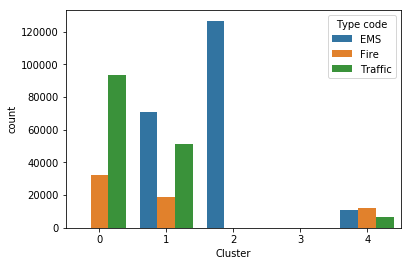

In [181]:
sns.countplot(x='Cluster',data=df, hue='Type code')

In [178]:
df['Cluster'].nunique()

5

In [177]:
df[df['Cluster']==3].head()

,lat,lng,desc,zip,title,timeStamp,Township,addr,e,Type code,...,Month,Week Day,Year,Date,Y,nTownship,ntitle,ndesc,Labels,Cluster
357795,22.986757,87.854975,RT202 SB & RAMP RT202 SB TO I76 WB; UPPER MERI...,Not Available,Traffic: VEHICLE ACCIDENT -,2018-06-11 16:59:29,UPPER MERION,RT202 SB & RAMP RT202 SB TO I76 WB,1,Traffic,...,Jun,Mon,2018,2018-06-11,0,12,9,357731,0,3
369428,26.820553,30.802498,RAMP EGYPT RD TO RT422 EB & EGYPT RD; UPPER PR...,Not Available,Traffic: VEHICLE ACCIDENT -,2018-07-10 08:10:38,UPPER PROVIDENCE,RAMP EGYPT RD TO RT422 EB & EGYPT RD,1,Traffic,...,Jul,Tue,2018,2018-07-10,0,42,9,369363,0,3
398440,0.000000,0.000000,RAMP EGYPT RD TO RT422 & EGYPT RD; UPPER PRO...,Not Available,EMS: UNKNOWN MEDICAL EMERGENCY,2018-09-20 07:07:49,UPPER PROVIDENCE,RAMP EGYPT RD TO RT422 & EGYPT RD,1,EMS,...,Sep,Thu,2018,2018-09-20,1,42,15,398372,0,3
398739,22.986757,87.854975,RAMP RT202 SB TO I76 WB & RAMP N GULPH RD TO I...,Not Available,Traffic: DISABLED VEHICLE -,2018-09-20 20:01:42,UPPER MERION,RAMP RT202 SB TO I76 WB & RAMP N GULPH RD TO I...,1,Traffic,...,Sep,Thu,2018,2018-09-20,0,12,11,398671,0,3
398740,22.986757,87.854975,RAMP RT202 SB TO I76 WB & RAMP N GULPH RD TO I...,Not Available,Traffic: DISABLED VEHICLE -,2018-09-20 20:02:29,UPPER MERION,RAMP RT202 SB TO I76 WB & RAMP N GULPH RD TO I...,1,Traffic,...,Sep,Thu,2018,2018-09-20,0,12,11,398672,0,3


In [179]:
df[df['zip']=='Not Available'].head()

,lat,lng,desc,zip,title,timeStamp,Township,addr,e,Type code,...,Month,Week Day,Year,Date,Y,nTownship,ntitle,ndesc,Labels,Cluster
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,Not Available,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,EMS,...,Dec,Thu,2015,2015-12-10,1,3,4,4,1,1
10,40.231990,-75.251891,RT202 PKWY & KNAPP RD; MONTGOMERY; 2015-12-10 ...,Not Available,Traffic: VEHICLE ACCIDENT -,2015-12-10 17:33:50,MONTGOMERY,RT202 PKWY & KNAPP RD,1,Traffic,...,Dec,Thu,2015,2015-12-10,0,9,9,10,1,1
14,40.097222,-75.376195,SCHUYLKILL EXPY & CROTON RD UNDERPASS; UPPER M...,Not Available,Traffic: VEHICLE ACCIDENT -,2015-12-10 17:09:49,UPPER MERION,SCHUYLKILL EXPY & CROTON RD UNDERPASS,1,Traffic,...,Dec,Thu,2015,2015-12-10,0,12,9,14,1,1
23,40.143326,-75.422819,RT422 & PAWLINGS RD OVERPASS; LOWER PROVIDENC...,Not Available,Traffic: DISABLED VEHICLE -,2015-12-10 18:00:38,LOWER PROVIDENCE,RT422 & PAWLINGS RD OVERPASS,1,Traffic,...,Dec,Thu,2015,2015-12-10,0,15,11,23,1,1
24,40.153268,-75.189558,SUMMIT AVE & RT309 UNDERPASS; UPPER DUBLIN; 20...,Not Available,Traffic: VEHICLE ACCIDENT -,2015-12-10 17:58:22,UPPER DUBLIN,SUMMIT AVE & RT309 UNDERPASS,1,Traffic,...,Dec,Thu,2015,2015-12-10,0,16,9,24,1,1


# Conclusion

<b>
1. Data set has 423909 rows and 9 columns
2. maximum calls came from LOWER MERION, Least being LEHIGH COUNTY 
3. Maximum calls happen due to Vehicle accidents
4. Calls belong to the below three categories<br>
	a. EMS<br>
	b. Fire<br>
	c. Traffic<br>
5. Calls under EMS category is the highest reason , followed by Fire and Traffic
6. Jan, Mar and Oct seems to be the highest hitters for the entire dataset
7. 2015 data in the dataset seems to be having only a subset of the actual data. There seems to be a substantial jump in the number of call from 2015 to 2016.For all the years, the pattern seems to    be the same for all three type codes, EMS type code is at the top , followed by Traffic and Fire
8. Maximum calls happened between  4 PM and 6 PM for Traffic 
9. During March 2018 timeframe there has been a spike in the calls . Looking at the summary , looks like it is from LOWER MERION township that maximum calls originated 
   Based on the different venues, looks like the calls originated which are near to Office building
10. Looking at the heat map, 17:00 during week days seems to be the time when most of the calls happen
11. Word cloud has Traffic accidents clearly standing out
12. Logitic regression does not yield good results, Probably the dataset does not have enough for logitic regression to work. Maximum accuracy that was achieved was just 55 %
13. Clustering algorithm, segrated all the records where the zip codes are not available.<br>
	a. Cluster 0 - Maximum Traffic related calls<br>
	b. Cluster 1 - Maximum EMS related calls<br>
	c. Cluster 2 - Zip code is missing<br>
	d. Cluster 3 - where the calls were at the minimum
</b>